In [203]:
from random import choice, choices
from string import ascii_lowercase, digits
import numpy as np
from numpy.random import default_rng
import time
import pandas as pd
import seaborn as sns

from statsmodels.stats.proportion import multinomial_proportions_confint, proportion_confint
from scipy.stats import binom

from multiprocessing import Pool, cpu_count
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline


# Main algorithm functions

In [204]:
def sisson_glaz(sample_freqs, sample_probs, word_list):
    sis = pd.DataFrame(multinomial_proportions_confint(sample_freqs, method='sison-glaz'), 
                   columns=['ci_lower','ci_upper'])
    sis['exp_method'] = 'sison-glaz'
    sis['word'] = word_list
    sis['param_probs'] = sample_probs
    sis['sample_probs'] = sample_probs
    return sis[['word', 'sample_probs', 'param_probs', 'exp_method', 'ci_lower', 'ci_upper']]


def gt_orlitsky(sample, word_list):
    counts = pd.Series(sample).value_counts().reindex(word_list , fill_value=0)
    counts_of_counts = counts.value_counts()
    p = {}
    for c in (counts_of_counts.index):
        c_o_c_1 = counts_of_counts[c+1] if c+1 in counts_of_counts else 0
        if c > c_o_c_1:
            p[c] = (c/counts.sum())
        else:
            p[c] = (c_o_c_1+1) * (c+1) / (counts.sum() * counts_of_counts[c])
    new_p = counts.map(p)
    return list(new_p / new_p.sum())


In [205]:
def combined_ci_framwork(boot_list, ci_method, param_func_probs, sample_probs, sample_size, corrected_confidence,
                         num_of_bootstrap_smaples):
    
    if ci_method == 'good_bootstrap':
        max_probs_list = []
        for arr in boot_list: 
            if np.any(arr == 0):
                arr_prob = arr == 0
                max_prob = np.array(param_func_probs)[arr_prob].max()
                max_probs_list.append(max_prob)
        ci_bound_for_zero = np.quantile(max_probs_list,corrected_confidence, interpolation='lower')
   
    elif ci_method == 'rule_of_three':
        ci_bound_for_zero = -np.log(1-corrected_confidence)/sample_size
   
    ci_lower_list = [0]*len(sample_probs)
    ci_upper_list = [0]*len(sample_probs)
    
    for i in range(len(sample_probs)):
        if sample_probs[i] == 0:
            ci_lower_list[i] = 0
            ci_upper_list[i] = ci_bound_for_zero
        else:
            ci_lower_list[i], ci_upper_list[i] = proportion_confint(sample_probs[i]*sample_size, sample_size, 
                                                                    (1-corrected_confidence), method="beta")
    return ci_lower_list, ci_upper_list
      

In [206]:
def get_ci(boot_list, ci_method, probs, sample_size, corrected_confidence, num_of_bootstrap_smaples, sample_probs):
    boot_cis = pd.DataFrame()
    boot_cis['param_probs'] = probs
    
    if ci_method == 'percentile':
        boot_cis['ci_lower'] = np.quantile(boot_list,(1-corrected_confidence)/2, axis=0)
        boot_cis['ci_upper'] = np.quantile(boot_list,(1+corrected_confidence)/2, axis=0)

    elif ((ci_method == 'good_bootstrap') | (ci_method == 'rule_of_three')):
        boot_cis['ci_lower'], boot_cis['ci_upper'] = combined_ci_framwork(boot_list, ci_method, probs, 
                                                                          sample_probs, sample_size, 
                                                                          corrected_confidence, num_of_bootstrap_smaples)
    return boot_cis


In [207]:
def run_parametric_bootstrap_ci(sample_words_list, sample_probs, word_index, sample_size, num_of_bootstrap_smaples, 
                             param_dist_func, ci_method='percentile',confidence=.95, bonferroni_correction=True):
    """
    Custom function that generates parametric bootstrap confidence intervals for a sample of words from an alphabet. 

    :param sample_words_list: the raw sample
    :param sample_probs: the alphabet empirical probability vector
    :param word_index: the alphabet
    :param sample_size: the size of the sample taken
    :param num_of_bootstrap_smaples: how many bootstrap iterations to run
    :param param_dist_func: the parametric plug-in distribution to use
    :param ci_method: the method in which to calculate the confidence intervals (in current version can be one of: 'percentile', 'good_bootstrap', 'rule_of_three')
    :param confidence: the confidence level for the intervals
    :param bonferroni_correction: True to use the Bonferroni correction to control for FWER
    """
    
    bonf_corrected_alpha = (1-confidence)/len(word_index)
    corrected_confidence = 1-(bonf_corrected_alpha) if bonferroni_correction else confidence
    probs = param_dist_func(sample_words_list, word_index)
    
    boot_arr = default_rng().multinomial(sample_size, probs, size=num_of_bootstrap_smaples)
    boot_probs_list = list(boot_arr / boot_arr.sum(axis=1, keepdims=True))

    boot_cis = get_ci(boot_probs_list, ci_method, probs, sample_size, corrected_confidence,
                        num_of_bootstrap_smaples, sample_probs)
    
    boot_cis['exp_method'] = ci_method 

    boot_cis['word'] = word_index
    boot_cis['sample_probs'] = sample_probs

    return boot_cis[['word', 'sample_probs', 'param_probs', 'exp_method', 'ci_lower', 'ci_upper']].reset_index(drop=True)


# Running an experiment

### Experiment functions

In [208]:
def get_zipf_dist_probs(zipf_param, exp_alphabet_size):
    ranks = np.arange(1, exp_alphabet_size+1)
    weights = ranks ** (-zipf_param)
    exp_probs = (weights / sum(weights))
    return exp_probs


def get_word_list(size):
    chars = ascii_lowercase + digits
    word_list = [''.join(choice(chars) for _ in range(3)) for _ in range(size*2)]
    word_list = list(set(word_list))[:size]
    word_list.sort()
    return word_list


In [214]:
def run_experiment(sample_size, probs, word_list, dictionary, num_of_bootstrap_smaples, iteration=None):
    if iteration % 10 == 0: 
        print('iteration {}'.format(iteration))
    
    samp_exp = default_rng().multinomial(sample_size, probs, size=1).flatten()

    sample_exp_df = pd.DataFrame(np.transpose(samp_exp), index=word_list, columns=['samp'])
    sample_exp_df['probs'] = sample_exp_df['samp'] / sample_exp_df['samp'].sum()
    samp_raw = list(np.repeat(word_list, sample_exp_df.samp))
    
    sis = sisson_glaz(sample_exp_df.samp, sample_exp_df['probs'].to_list(), word_list)
    
    good_bootstrap = run_parametric_bootstrap_ci(samp_raw,sample_exp_df['probs'].to_list(), word_list, 
                                                 sample_size, num_of_bootstrap_smaples, 
                                                 gt_orlitsky, ci_method='good_bootstrap')
    rot = run_parametric_bootstrap_ci(samp_raw,sample_exp_df['probs'].to_list(), word_list, 
                                      sample_size, num_of_bootstrap_smaples, 
                                      gt_orlitsky, ci_method='rule_of_three')
    res = pd.concat([sis, good_bootstrap, rot], ignore_index=True)
    
    res.loc[res['ci_lower'] < 0, 'ci_lower'] = 0
    res.loc[res['ci_upper'] > 1, 'ci_upper'] = 1
    res['ci_length'] = res['ci_upper'] - res['ci_lower']
    res['log_ci_length'] = np.log(res['ci_length'])
    res['exp_num'] = iteration 
    res['true_prob'] = res['word'].map(dictionary)
    res['log_true_prob'] = np.log(res['true_prob'])
    res['in_ci'] = (res['true_prob'] >= res['ci_lower']) & \
                       (res['true_prob'] <= res['ci_upper'])
    
    return res

### Run experiment (parallel)

In [210]:
exp_alphabet_size = 1000
exp_sample_size = 200

exp_probs = get_zipf_dist_probs(1.01, exp_alphabet_size)
exp_word_list = get_word_list(exp_alphabet_size)
exp_dictionary = dict(zip(exp_word_list, exp_probs))

exp_bootstrap_smaples = 10000

In [215]:

experiment_runs = 100
pool = Pool(cpu_count()-2)
func = partial(run_experiment, exp_sample_size, exp_probs, exp_word_list, exp_dictionary, exp_bootstrap_smaples)

start_time = time.time()
pooled_results = pool.starmap(func, zip(range(experiment_runs)))
pool.close()
pool.join()
print("\n *********** process run time {} minutes ***********".format((time.time() - start_time)/60))


iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90

 *********** process run time 6.398239934444428 minutes ***********


In [216]:
exp_results = pd.concat(pooled_results)
exp_results.head()

,word,sample_probs,param_probs,exp_method,ci_lower,ci_upper,ci_length,log_ci_length,exp_num,true_prob,log_true_prob,in_ci
0,01x,0.140,0.140,sison-glaz,0.095,0.191469,0.096469,-2.338529,0,0.137874,-1.981412,True
1,03a,0.080,0.080,sison-glaz,0.035,0.131469,0.096469,-2.338529,0,0.068461,-2.681491,True
2,03y,0.050,0.050,sison-glaz,0.005,0.101469,0.096469,-2.338529,0,0.045456,-3.091011,True
3,06m,0.025,0.025,sison-glaz,0.000,0.076469,0.076469,-2.570863,0,0.033994,-3.381570,True
4,07e,0.045,0.045,sison-glaz,0.000,0.096469,0.096469,-2.338529,0,0.027135,-3.606945,True


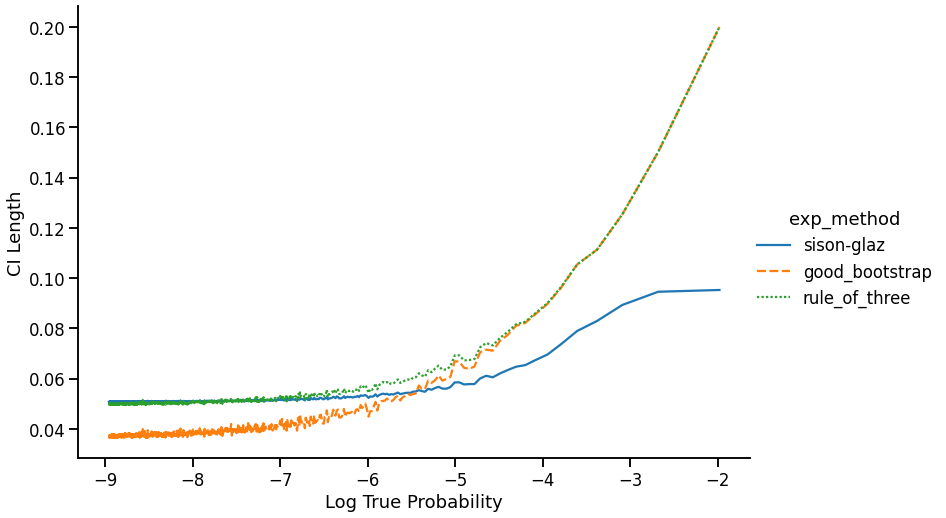

In [218]:
g = sns.relplot(x='log_true_prob', y='ci_length',
                hue='exp_method', style='exp_method', 
                kind='line', ci=None,
                height=7, aspect=1.5,
                data=exp_results)
g.set_axis_labels("Log True Probability", 'CI Length')

In [223]:
res_by_exp = exp_results.groupby(['exp_num','exp_method']).agg(in_ci = ('in_ci', 'sum'),
                                                               log_ci_volume = ('log_ci_length', 'sum')).reset_index()
res_by_exp['all_in_ci'] = res_by_exp['in_ci'] == len(exp_word_list)

res_by_exp.groupby(['exp_method']).agg(experiments_with_all_word_coverage = ('all_in_ci', 'sum'),
                                       log_ci_volume_mean = ('log_ci_volume', 'mean'))

,experiments_with_all_word_coverage,log_ci_volume_mean
exp_method,,
good_bootstrap,99,-3255.594589
rule_of_three,99,-2969.441550
sison-glaz,89,-2969.861117
